This latest version of the code provides a number of new effects.
1.  $\bf{DM\to \Delta f_\gamma}$. DM energy injection produces low energy photons that contribute to the blackbody distortion.
2.  $\bf{f_{exc,nl}\to \Delta f_\gamma}$. Some of that energy excites hydrogen atoms to the $nl$ excited state. These atoms then transition through many other excited states, producing or absorbing line photons that contribute to the distortion.
3.  $\bf{f_{exc,nl}\to \dot{x}_e}$. Sometimes these excited state transitions end in an ionization.
{4.  $\bf{f_{ion}\to \Delta f_\gamma}$. Extra ionization means extra photon absorption, and also an increase in recombinations, both of which affect the distortion.}
5. $\bf{\Delta f_\gamma \to \dot{x}_e}$. All rates -- recombination, ionization, and atomic transitions -- depend on the photon phase space density.  When $\Delta f_\gamma$ is non-zero, the rates change, and the ionization rate changes.
6. $\bf{\Delta f_\gamma \to \Delta f_\gamma}$. The distortion can be reprocessed over time, e.g. photons that are emitted at early times can be absorbed at later times.

In [3]:
import sys
sys.path.append('../..')

import config
import main
import pickle

import numpy as np
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d

import darkhistory.physics as phys
from darkhistory.spec.spectra import Spectra
from darkhistory.spec.spectrum import Spectrum
import darkhistory.low_energy.atomic as atomic
import darkhistory.spec.spectools as spectools

In [2]:
import csv

def download_plot(file):
    with open('/Users/gregoryridgway/Desktop/Webplot_distortion/'+file+'.csv') as csvfile:
        reader = csv.reader(csvfile)
        goods = []
        for row in reader:
            goods.append([float(r) for r in row])
            
        goods = np.array(goods)

    return goods

n10_data = download_plot('n10')
n20_data = download_plot('n20')
n30_data = download_plot('n30')
jens_data = download_plot('Full_Distortion')
jens_2s = download_plot('DeltaR_2s_jens')
jens_2p = download_plot('DeltaR_2p_jens')
BB_BF_jens = download_plot('BB_plus_BF_dist')

# Data from Jens Chluba et al's papers
# plt.plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='k',
#          linewidth=1.2, label='Chluba+Sunyaev', alpha=0.6)
# plt.plot(n10_data[:,0], n10_data[:,1], color='k',
#          linewidth=2.0, linestyle='--', label='Jens+')
# plt.plot(n20_data[:,0], n20_data[:,1], color='k', linewidth=1.0, linestyle=':')
# plt.plot(n30_data[:,0], n30_data[:,1], color='k', linewidth=1.2)
# plt.plot(jens_data[:,0], jens_data[:,1], color='k', linewidth=2.0, linestyle='--')

In [4]:
%autoreload
def Gy(nu):
    return phys.ymu_distortion(nu, 1/4, phys.TCMB(1) / phys.kB, dist_type='y')

def y_dist_test(nu, result, mDM, lifetime, coarsen_factor=1):
    rs_list = result['rs']
    
    # nu is the frequencies in Hz over which to calculate the distortion
    weights = result['f']['heat'] * phys.inj_rate('decay', rs_list,
                                                  mDM=mDM, lifetime=lifetime)
    weights /= phys.CMB_eng_density(phys.TCMB(rs_list))
    
    weights[rs_list < 100] = 0
    return (
        Gy(nu) # Green's function
        * np.sum(weights * .001 * coarsen_factor / phys.hubble(rs_list)) # integrate over redshift
        * 1e4 * phys.ele # units of W / m^2 / ster / Hname
    )

# data1 = (
#     y_dist_test(nu, DM_run_withf, mDM, lifetime, coarsen_factor)
# )

In [51]:
from scipy.interpolate import interp2d
input_dir = config.data_path

decay_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])

f_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_swave.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1]

f_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_swave.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1]

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

decay_elec_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])

#Derived from Planck 2018 cosmological parameters
p_ann = 3.5e-28

def param_bound_elec_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_elec_CMB(mDM*1e-9)])[0]

def param_bound_phot_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_phot_CMB(mDM*1e-9)])[0]
    
def param_bound(mDM, DM_process, pri):
    if pri == 'elec':
        return param_bound_elec_CMB(mDM, DM_process)
    else:
        return param_bound_phot_CMB(mDM, DM_process)

# 1. Distortion, DM component

In [197]:
%autoreload

pri = 'elec'
DM_process = 'decay'
# mDM = 2e8
# mDM = 10**log10eng[::10][1] + phys.me
mDM = 10**6.5
nmax=10

param = param_bound(mDM, DM_process, pri)
coarsen_factor = 16
string = str(int(np.floor(np.log10(mDM))))
start_rs = 3e3
end_rs = 5

# baseline = main.evolve(
#     DM_process=DM_process, mDM=mDM,
#     lifetime=param*1e20,
#     sigmav=param,
#     primary=pri+'_delta',
#     start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
#     coarsen_factor=coarsen_factor,
#     distort=True, recfast_TLA=True,
#     fexc_switch = False, nmax=nmax
# )

DMrun = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param,
    sigmav=param,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=coarsen_factor,
    distort=True, recfast_TLA=True,
    fexc_switch = False, 
    reprocess_distortion=False, 
    nmax=nmax
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:466: RuntimeWarning: overflow encountered in true_divide
  K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:470: RuntimeWarning: overflow encountered in double_scalars
  K[0][1] = BB['dn'][2][1][0] / tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHist

In [198]:
# spectra of lowengphots
tmp = DMrun['lowengphot'].copy()

# mask out ionizing photons
mask = np.array(list(map(float,tmp.eng<13.6)))
tmp._grid_vals = tmp._grid_vals * mask

# redshift then sum
tmp.redshift(1.)
tmp = tmp.sum_specs()

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

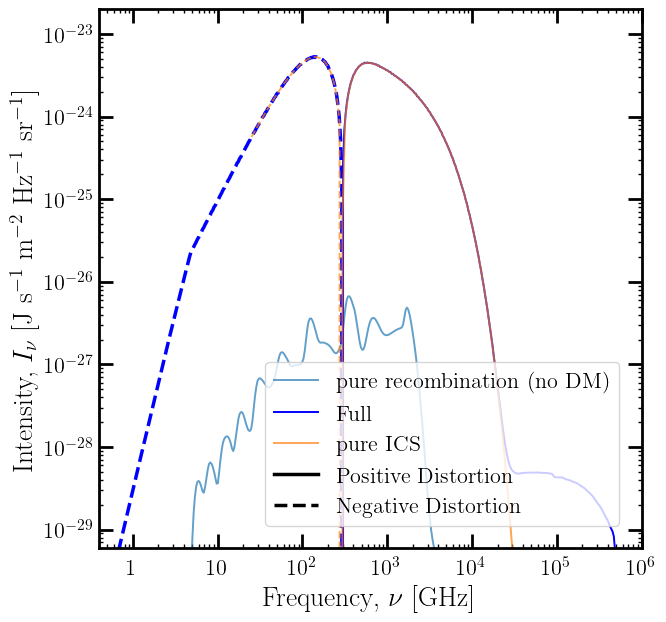

In [201]:
eng = baseline['distortion'].eng

hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
rs_fac = 1300


plt.figure(figsize=(7, 7))
plt.loglog()
plt.xlim([4e-1, 1e6])
plt.ylim([6e-30, 2e-23])

# DH generated data
plt.plot(nu/1e9, convert * baseline['distortion'].dNdE,
         color='C0', linewidth=1.4, label='pure recombination (no DM)', alpha=0.7)
# plt.plot(nu/1e9, convert * DMrun['distortion'].dNdE,
#          color='blue', linewidth=1.4, label='w/ DM, (+)')
# plt.plot(nu/1e9, -convert * DM_run['distortion'].dNdE,
#          color='red', linewidth=1.4, label='w/ DM, (-)')

plt.plot(nu/1e9, convert * DMrun['distortion'].dNdE,
         color='blue', linewidth=1.4, label='Full')
plt.plot(nu/1e9, -convert * DMrun['distortion'].dNdE,
         color='blue', linestyle='--')

plt.plot(tmp.eng/hplanck/1e9, phys.nB * tmp.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4 * tmp.dNdE,
         color='C1', linewidth=1.4, label='pure ICS', alpha=0.7)
plt.plot(tmp.eng/hplanck/1e9, -phys.nB * tmp.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4 * tmp.dNdE,
         color='C1', linestyle='--', linewidth=1.4, alpha=0.7)

plt.plot(nu/1e9, np.ones_like(nu), color='k', 
         linestyle='solid', label='Positive Distortion')
plt.plot(nu/1e9, np.ones_like(nu), color='k', 
         linestyle='--', label='Negative Distortion')

plt.legend(loc=4)

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

# 2. $f_{exc}$ as a distortion source

In [104]:
%autoreload
DMrun_withf = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=lifetime,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=coarsen_factor,
    distort=True, recfast_TLA=True,
    fexc_switch = True, reprocess_distortion=False, nmax=nmax
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:466: RuntimeWarning: overflow encountered in true_divide
  K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:470: RuntimeWarning: overflow encountered in double_scalars
  K[0][1] = BB['dn'][2][1][0] / tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHist

Text(0.5, 1.0, 'CMB Spectral Distortion due to DM Decay to $e^+e^-$')

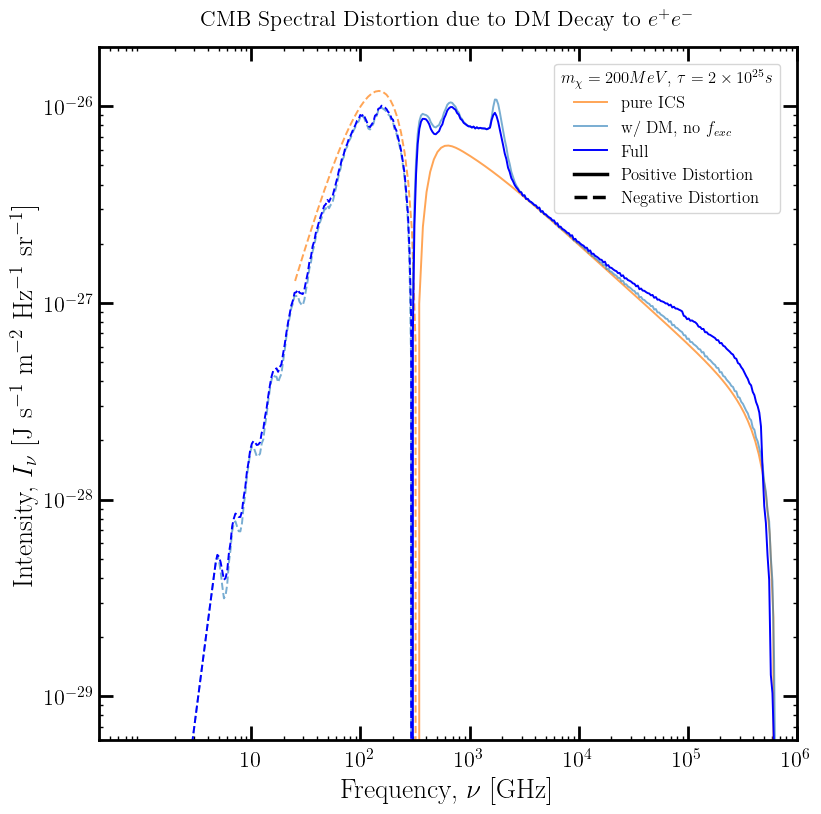

In [117]:
eng = baseline['distortion'].eng

hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
# rs_fac = 1300


plt.figure(figsize=(7, 7))
plt.loglog()
# plt.xscale('log')
plt.xlim([4e-1, 1e6])
plt.ylim([6e-30, 2e-26])

# DH generated data
plt.plot(tmp.eng/hplanck/1e9, phys.nB * tmp.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4 * tmp.dNdE,
         color='C1', linewidth=1.4, label='pure ICS', alpha=0.7)
plt.plot(tmp.eng/hplanck/1e9, -phys.nB * tmp.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4 * tmp.dNdE,
         color='C1', linestyle='--', linewidth=1.4, alpha=0.7)

plt.plot(nu/1e9, convert * DMrun['distortion'].dNdE,
         color='C0', linewidth=1.4,
         label='w/ DM, no $f_{exc}$', linestyle='solid', alpha=0.6)
plt.plot(nu/1e9, -convert * DMrun['distortion'].dNdE,
         color='C0', linewidth=1.4,
         linestyle='--', alpha=0.6)

plt.plot(nu/1e9, convert * DMrun_withf['distortion'].dNdE,
         color='blue', linestyle='solid', linewidth=1.4, label='Full')
plt.plot(nu/1e9, -convert * DMrun_withf['distortion'].dNdE,
         color='blue', linestyle='--', linewidth=1.4)

plt.plot(nu/1e9, np.ones_like(nu), color='k', 
         linestyle='solid', label='Positive Distortion')
plt.plot(nu/1e9, np.ones_like(nu), color='k', 
         linestyle='--', label='Negative Distortion')

plt.xticks([1e1,1e2,1e3,1e4,1e5,1e6])

leg = plt.legend(fontsize=12)
leg.set_title(r'$m_\chi = 200 MeV$, $\tau = 2 \times 10^{25}s$')
plt.setp(leg.get_title(),fontsize='12')


plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)
plt.title('CMB Spectral Distortion due to DM Decay to $e^+e^-$', fontsize=16)

# 3. $f_{exc}$ as an ionization source

In [219]:
rs_vec = DM_run0['rs']

Tr_vec, Tm_vec  = phys.TCMB(rs_vec), phys.Tm_std(rs_vec)
# Tm_vec = Tr_vec.copy()

xe_vec, x1s_vec  = phys.xHII_std(rs_vec), phys.xHI_std(rs_vec)
nH_vec = phys.nH * rs_vec**3

tau_vec = atomic.tau_np_1s(2,rs_vec)
x2s_vec = atomic.x2s_steady_state(rs_vec, Tr_vec, Tm_vec, xe_vec, x1s_vec, tau_vec)
x2_vec  = 4*x2s_vec

Text(0, 0.5, 'Fractional Difference in Ionization Rate')

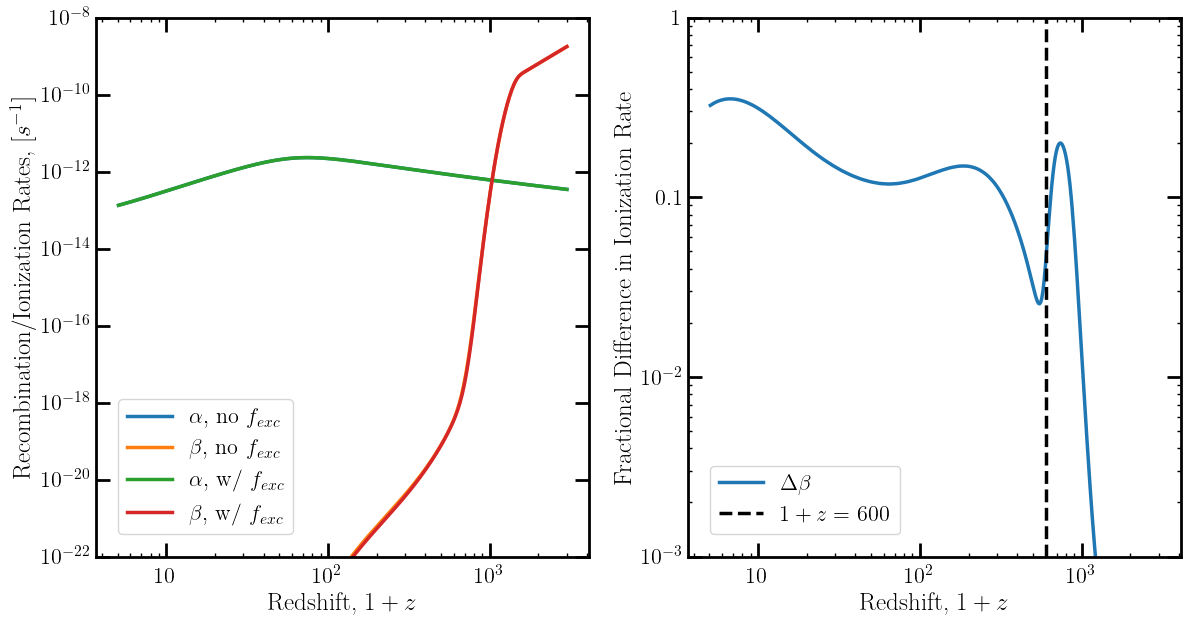

In [18]:
fig, axarr = plt.subplots(1,2, figsize=(14, 7))
axarr[0].loglog()
axarr[0].set_ylim([1e-22, 1e-8])

axarr[0].plot(DMrun_withf['rs'], DMrun_withf['MLA'][0][1:], label=r'$\alpha$, no $f_{exc}$')
axarr[0].plot(DMrun_withf['rs'], DMrun_withf['MLA'][1][1:], label=r'$\beta$, no $f_{exc}$')

axarr[0].plot(DMrun['rs'], DMrun['MLA'][0][1:], label=r'$\alpha$, w/ $f_{exc}$')
axarr[0].plot(DMrun['rs'], DMrun['MLA'][1][1:], label=r'$\beta$, w/ $f_{exc}$')

# axarr[0].plot(DM_run0['rs'], phys.alpha_recomb(Tm_vec, 'HI') + 0*xe_vec**2*nH_vec)
# rate = phys.beta_ion(Tr_vec, 'HI') * x2_vec
# axarr[0].plot(DM_run0['rs'], rate)

axarr[0].set_xlabel('Redshift, $1+z$')
axarr[0].set_ylabel('Recombination/Ionization Rates, [$s^{-1}$]')
axarr[0].legend()

# plt.plot(DM_run_withf0['rs'], np.abs(DM_run_withf0['MLA'][0][1:]/DM_run0['MLA'][0][1:]-1),
#          label=r'$\alpha$')


axarr[1].loglog()
axarr[1].set_ylim([1e-3, 1])
axarr[1].plot(DMrun_withf['rs'], DMrun_withf['MLA'][1][1:]/DMrun['MLA'][1][1:]-1,
         label=r'$\Delta \beta$')

axarr[1].axvline(600, linestyle='--', color='k', label=r'$1+z=600$')

axarr[1].legend()
axarr[1].set_xlabel('Redshift, $1+z$')
axarr[1].set_ylabel('Fractional Difference in Ionization Rate')

Text(0, 0.5, 'Fractional Difference in Ionization Rate')

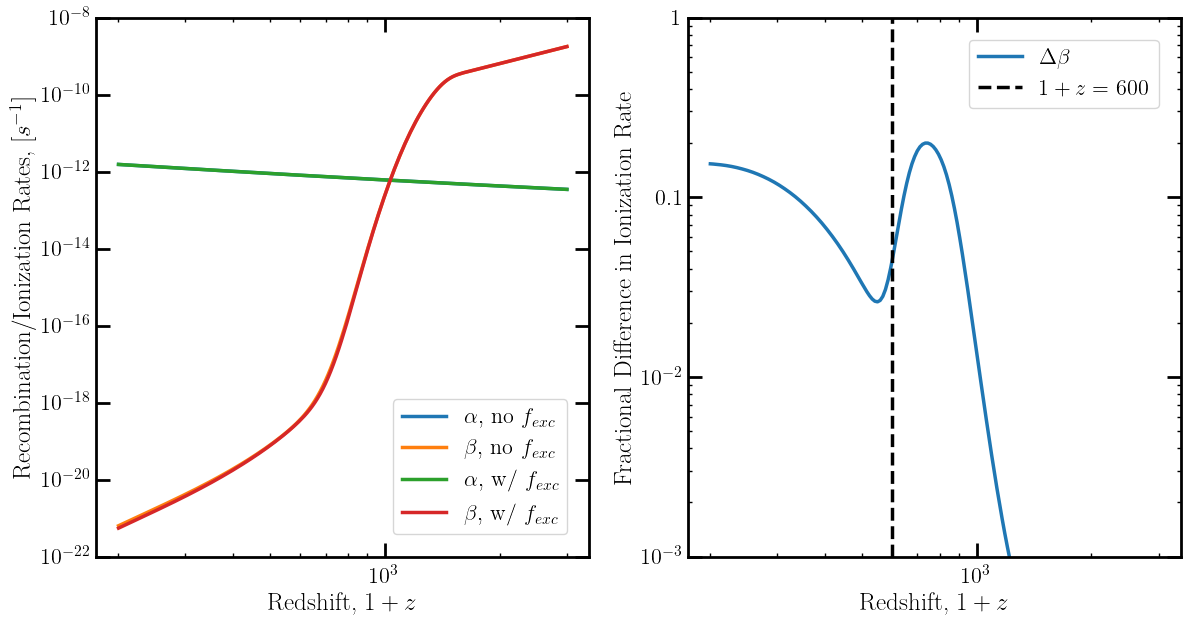

In [225]:
fig, axarr = plt.subplots(1,2, figsize=(14, 7))
axarr[0].loglog()
axarr[0].set_ylim([1e-22, 1e-8])

axarr[0].plot(DM_run_withf0['rs'], DMrun_withf['MLA'][0][1:], label=r'$\alpha$, no $f_{exc}$')
axarr[0].plot(DM_run_withf0['rs'], DMrun_withf['MLA'][1][1:], label=r'$\beta$, no $f_{exc}$')

axarr[0].plot(DM_run0['rs'], DMrun['MLA'][0][1:], label=r'$\alpha$, w/ $f_{exc}$')
axarr[0].plot(DM_run0['rs'], DMrun['MLA'][1][1:], label=r'$\beta$, w/ $f_{exc}$')

# axarr[0].plot(DM_run0['rs'], phys.alpha_recomb(Tm_vec, 'HI') + 0*xe_vec**2*nH_vec)
# rate = phys.beta_ion(Tr_vec, 'HI') * x2_vec
# axarr[0].plot(DM_run0['rs'], rate)

axarr[0].set_xlabel('Redshift, $1+z$')
axarr[0].set_ylabel('Recombination/Ionization Rates, [$s^{-1}$]')
axarr[0].legend()

# plt.plot(DM_run_withf0['rs'], np.abs(DM_run_withf0['MLA'][0][1:]/DM_run0['MLA'][0][1:]-1),
#          label=r'$\alpha$')


axarr[1].loglog()
axarr[1].set_ylim([1e-3, 1])
axarr[1].plot(DMrun_withf['rs'], DMrun_withf['MLA'][1][1:]/DMrun['MLA'][1][1:]-1,
         label=r'$\Delta \beta$')

axarr[1].axvline(600, linestyle='--', color='k', label=r'$1+z=600$')

axarr[1].legend()
axarr[1].set_xlabel('Redshift, $1+z$')
axarr[1].set_ylabel('Fractional Difference in Ionization Rate')

In [235]:
# import pickle
# MLA_data = pickle.load(open(
#     '/Users/gregoryridgway/Desktop/Data/'+
#     'MLA_rates_nmax100_nlogdlnz3.0_endrs200fudge1.125.dat', 'rb'
# ))

# MLA_funcs = np.array([
#     interp1d(DM_run_withf0['rs'], DM_run_withf0['MLA'][0][1:]),
#     interp1d(np.log(DM_run_withf0['rs']), np.log(DM_run_withf0['MLA'][1:]))
# ])

In [118]:
from darkhistory.history import tla

MLA_funcs = np.array([
    interp1d(DMrun['rs'], DMrun['MLA'][0][1:]),
    interp1d(np.log(DMrun['rs']), np.log(DMrun['MLA'][1][1:]))
])

f_raw = {key: interp1d(DMrun['rs'], DMrun['f'][key],
                       bounds_error=False, fill_value = (0,0))
         for key in DMrun['f'].keys()}

def f_H_ion(rs, xHI, xHeI, xHeII):
    return f_raw['H ion'](rs)
def f_heat(rs, xHI, xHeI, xHeII):
    return f_raw['heat'](rs)
def f_H_exc(rs, xHI, xHeI, xHeII):
    return f_raw['Lya'](rs)

def rate_func_eng(rs):
    return phys.inj_rate(DM_process, rs, mDM=mDM, lifetime=lifetime)

rs_vec = np.exp(np.arange(np.log(3e3),np.log(5.4),-.001*16))

iterated = tla.get_history(
    rs_vec, high_rs=np.inf,
    f_H_ion=f_H_ion, f_H_exc=f_H_exc, f_heating=f_heat,
    injection_rate=rate_func_eng,
    recfast_TLA=False,
    alpha_MLA=MLA_funcs[0], beta_MLA=MLA_funcs[1],
    mxstep=10000, rtol=1e-8
)

MLA_funcs = np.array([
    interp1d(DMrun_withf['rs'], DMrun_withf['MLA'][0][1:]),
    interp1d(np.log(DMrun_withf['rs']), np.log(DMrun_withf['MLA'][1][1:]))
])

iterated_withf = tla.get_history(
    rs_vec, high_rs=np.inf,
    f_H_ion=f_H_ion, f_H_exc=f_H_exc, f_heating=f_heat,
    injection_rate=rate_func_eng,
    recfast_TLA=False,
    alpha_MLA=MLA_funcs[0], beta_MLA=MLA_funcs[1],
    mxstep=10000, rtol=1e-8
)

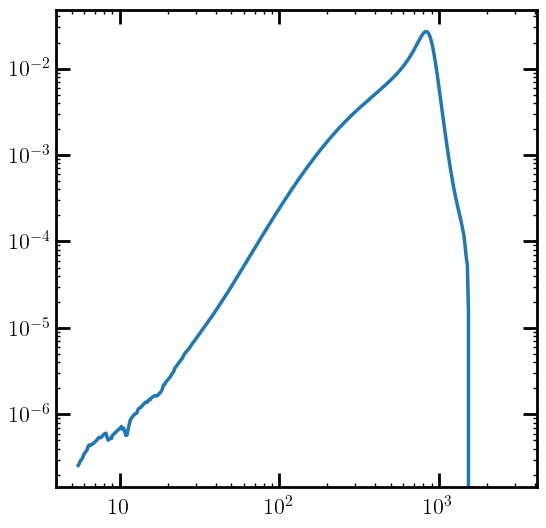

In [122]:
plt.figure()
plt.loglog()
# plt.plot(rs_vec, perturbed[:,1])
# plt.plot(rs_vec, perturbed0[:,1])

plt.plot(rs_vec, iterated_withf[:,1]/iterated[:,1]-1)
# plt.plot(rs_vec, iterated[:,1]/phys.xHII_std(rs_vec)-1)

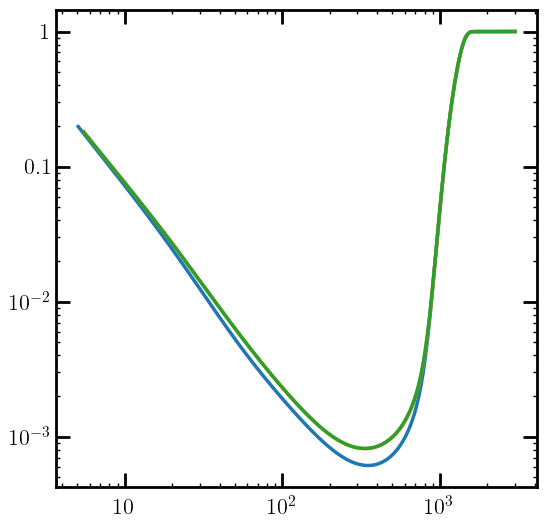

In [120]:
plt.figure()
plt.loglog()

plt.plot(DMrun['rs'], DMrun['x'][:,0])
# plt.plot(baseline['rs'], baseline['x'][:,0])
plt.plot(rs_vec, iterated[:,1])
plt.plot(rs_vec, iterated_withf[:,1])

# 4. $f_{ion}$ as a distortion source

In [198]:
%autoreload
DMrun_withf_nofion = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=lifetime,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=coarsen_factor,
    distort=True, recfast_TLA=True,
    fexc_switch = True, reprocess_distortion=False, nmax=nmax
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:442: RuntimeWarning: overflow encountered in true_divide
  K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:446: RuntimeWarning: overflow encountered in double_scalars
  K[0][1] = BB['dn'][2][1][0] / tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:442: RuntimeWarning: divide by zero encountered in true_divide
  K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:446: RuntimeWarning: divide by zero encountered in double_scalars
  K[0][1] = BB['dn'][2][1][0] / tot_rate
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/D

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

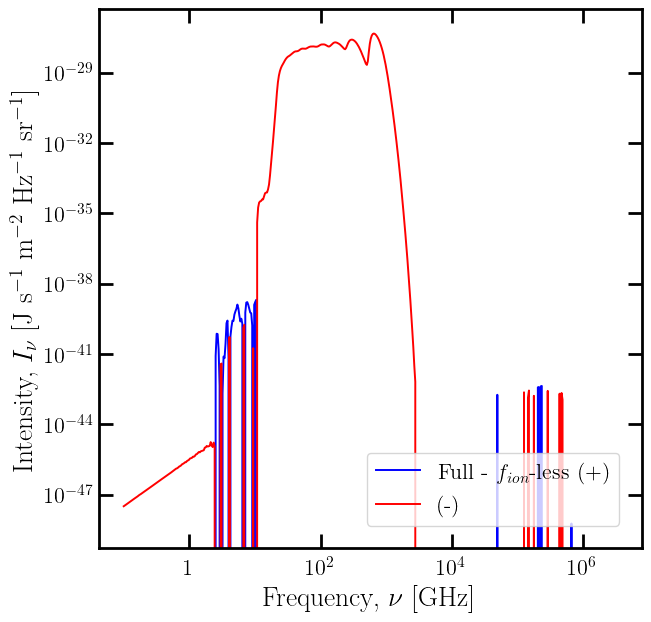

In [209]:
eng = baseline['distortion'].eng

hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
# rs_fac = 1300


plt.figure(figsize=(7, 7))
plt.loglog()
# plt.xlim([4e-1, 1e6])
# plt.ylim([6e-30, 2e-26])

# DH generated data
# plt.plot(nu/1e9, convert * baseline['distortion'].dNdE,
#          color='C0', linewidth=1.4, label='no DM')
# plt.plot(nu/1e9, convert * DM_run['distortion'].dNdE,
#          color='blue', linewidth=1.4,
#          label='w/ DM, no $f_{exc}$, (+)', linestyle='--', alpha=0.6)
# plt.plot(nu/1e9, -convert * DM_run['distortion'].dNdE,
#          color='red', linewidth=1.4,
#          label='(-)', linestyle='--', alpha=0.6)

# plt.plot(nu/1e9, convert * DM_run_withf['distortion'].dNdE,
#          color='blue', linewidth=1.4, label='w/ DM, w/ $f_{exc}$, (+)')
# plt.plot(nu/1e9, -convert * DM_run_withf['distortion'].dNdE,
#          color='red', linewidth=1.4)

plt.plot(nu/1e9, convert * (
    DM_run_withf['distortion'].dNdE - DM_run_withf_BF0['distortion'].dNdE),
         color='blue', linewidth=1.4, label='Full - $f_{ion}$-less (+)')
plt.plot(nu/1e9, -convert * (
    DM_run_withf['distortion'].dNdE - DM_run_withf_BF0['distortion'].dNdE),
         color='red', linewidth=1.4, label='(-)')

plt.legend(loc=4)

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

# 4. Distortion ($\Delta f_\gamma$) as an ionization source

In [123]:
%autoreload
DM_run_withf_withDf = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=lifetime,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=coarsen_factor, backreaction=True,
    distort=True, recfast_TLA=True,
    fexc_switch = True, reprocess_distortion=True, nmax=nmax
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


In [137]:
MLA_funcs = np.array([
    interp1d(DM_run_withf_withDf['rs'], DM_run_withf_withDf['MLA'][0][1:]),
    interp1d(np.log(DM_run_withf_withDf['rs']), np.log(DM_run_withf_withDf['MLA'][1][1:]))
])

iterated_withf_withDf = tla.get_history(
    rs_vec, high_rs=np.inf,
    f_H_ion=f_H_ion, f_H_exc=f_H_exc, f_heating=f_heat,
    injection_rate=rate_func_eng,
    recfast_TLA=False,
    alpha_MLA=MLA_funcs[0], beta_MLA=MLA_funcs[1],
    mxstep=10000, rtol=1e-8
)

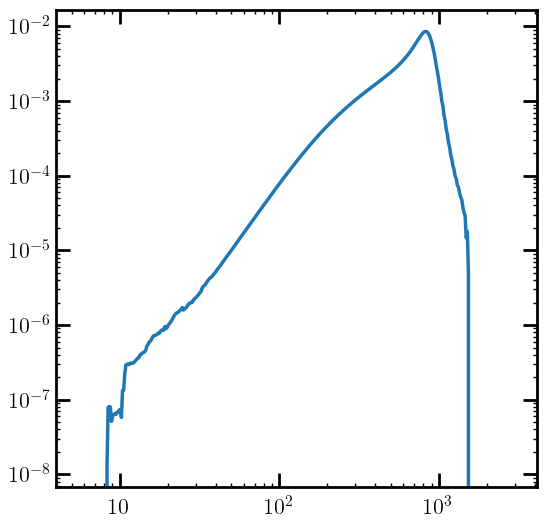

In [141]:
plt.figure()
plt.loglog()
# plt.plot(rs_vec, perturbed[:,1])
# plt.plot(rs_vec, perturbed0[:,1])

# plt.plot(rs_vec, iterated_withf[:,1]/iterated[:,1]-1)
plt.plot(rs_vec, iterated_withf_withDf[:,1]/iterated_withf[:,1]-1)
# plt.plot(rs_vec, iterated_withf_withDf[:,1]/iterated[:,1]-1)
# plt.plot(rs_vec, iterated[:,1]/phys.xHII_std(rs_vec)-1)

# 5. Reprocessing of distortion ($\Delta f_\gamma \to $ distortion)

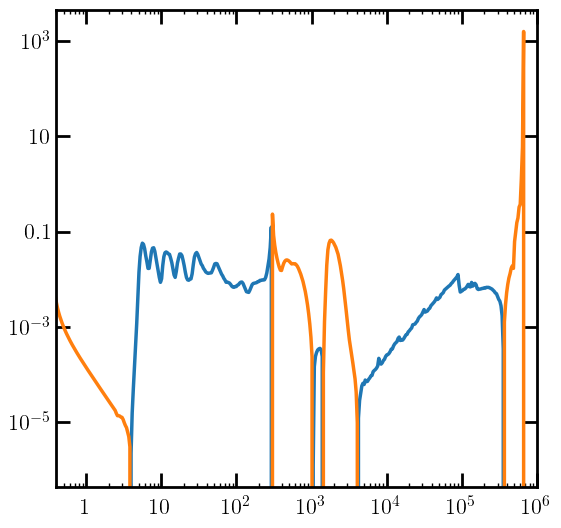

In [132]:
plt.figure()
plt.loglog()
# plt.xscale('log')
plt.xlim([4e-1, 1e6])
# plt.ylim([6e-30, 2e-26])

plt.plot(nu/1e9,
    (DM_run_withf_withDf['distortion'].dNdE+1e-200
    )/(DMrun_withf['distortion'].dNdE + 1e-200)-1
)
plt.plot(nu/1e9,
    1-(DM_run_withf_withDf['distortion'].dNdE+1e-200
    )/(DMrun_withf['distortion'].dNdE + 1e-200)
)

Text(0.5, 1.0, 'CMB Spectral Distortion due to DM Decay to $e^+e^-$')

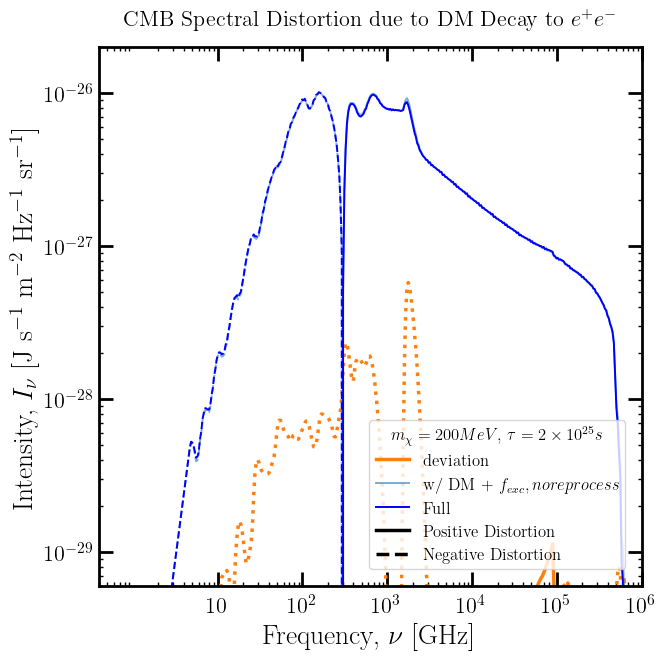

In [135]:
eng = baseline['distortion'].eng

hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
# rs_fac = 1300


plt.figure(figsize=(7, 7))
plt.loglog()
# plt.xscale('log')
plt.xlim([4e-1, 1e6])
plt.ylim([6e-30, 2e-26])

# DH generated data
# plt.plot(tmp.eng/hplanck/1e9, phys.nB * tmp.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4 * tmp.dNdE,
#          color='C1', linewidth=1.4, label='pure ICS', alpha=0.7)
# plt.plot(tmp.eng/hplanck/1e9, -phys.nB * tmp.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4 * tmp.dNdE,
#          color='C1', linestyle='--', linewidth=1.4, alpha=0.7)

plt.plot(nu/1e9,
         convert*(DM_run_withf_withDf['distortion'].dNdE-DMrun_withf['distortion'].dNdE),
         color='C1',
         label='deviation'
)
plt.plot(nu/1e9,
         -convert*(DM_run_withf_withDf['distortion'].dNdE-DMrun_withf['distortion'].dNdE),
         color='C1',
         linestyle=':'
)

plt.plot(nu/1e9, convert * DMrun_withf['distortion'].dNdE,
         color='C0', linewidth=1.4,
         label='w/ DM + $f_{exc}$, no reprocess', linestyle='solid', alpha=0.6)
plt.plot(nu/1e9, -convert * DMrun_withf['distortion'].dNdE,
         color='C0', linewidth=1.4,
         linestyle='--', alpha=0.6)

plt.plot(nu/1e9, convert * DM_run_withf_withDf['distortion'].dNdE,
         color='blue', linestyle='solid', linewidth=1.4, label='Full')
plt.plot(nu/1e9, -convert * DM_run_withf_withDf['distortion'].dNdE,
         color='blue', linestyle='--', linewidth=1.4)

plt.plot(nu/1e9, np.ones_like(nu), color='k', 
         linestyle='solid', label='Positive Distortion')
plt.plot(nu/1e9, np.ones_like(nu), color='k', 
         linestyle='--', label='Negative Distortion')

plt.xticks([1e1,1e2,1e3,1e4,1e5,1e6])

leg = plt.legend(fontsize=12)
leg.set_title(r'$m_\chi = 200 MeV$, $\tau = 2 \times 10^{25}s$')
plt.setp(leg.get_title(),fontsize='12')


plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)
plt.title('CMB Spectral Distortion due to DM Decay to $e^+e^-$', fontsize=16)

## ???

In [243]:
%autoreload
DM_run_withf_withDf = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=lifetime,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=coarsen_factor, backreaction=True,
    cross_check=False, distort=True, recfast_TLA=True,
    fexc_switch = True, reprocess_distortion=True, nmax=nmax
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:466: RuntimeWarning: overflow encountered in true_divide
  b[nl] += xHI*BB['dn'][2][1][0]*np.exp(-phys.lya_eng/Tr)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:470: RuntimeWarning: overflow encountered in double_scalars
  spec_ind = str(n) + num_to_l(l)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/exam

In [295]:
rs_cut = 5

tmp = DM_run_withf_withDf2['distortions'].copy()
tmp.redshift(1.)

mask = np.ones_like(tmp.rs)
mask[DM_run_withf_withDf2['distortions'].rs < rs_cut] = 0

tmp = tmp.sum_specs(mask)

tmp2 = DM_run_withf['distortions'].copy()
tmp2.redshift(1.)

mask = np.ones_like(tmp2.rs)
mask[DM_run_withf['distortions'].rs < rs_cut] = 0

tmp2 = tmp2.sum_specs(mask)

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

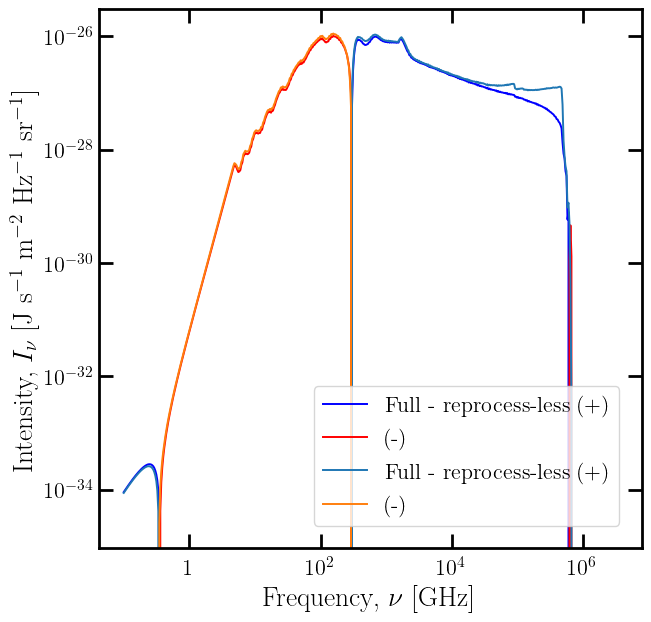

In [297]:
eng = baseline['distortion'].eng

plt.figure(figsize=(7, 7))
plt.loglog()

hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck

# plt.plot(nu/1e9, convert * (
#     DM_run_withf_withDf2['distortion'].dNdE - DM_run_withf_withDf['distortion'].dNdE),
#          color='blue', linewidth=1.4, label='Full - reprocess-less (+)')
# plt.plot(nu/1e9, -convert * (
#     DM_run_withf_withDf2['distortion'].dNdE - DM_run_withf_withDf['distortion'].dNdE),
#          color='red', linewidth=1.4, label='(-)')

plt.plot(nu/1e9, convert * tmp.dNdE,
         color='blue', linewidth=1.4, label='Full - reprocess-less (+)')
plt.plot(nu/1e9, -convert * tmp.dNdE,
         color='red', linewidth=1.4, label='(-)')

plt.plot(nu/1e9, convert * tmp2.dNdE,
         color='C0', linewidth=1.4, label='Full - reprocess-less (+)')
plt.plot(nu/1e9, -convert * tmp2.dNdE,
         color='C1', linewidth=1.4, label='(-)')

plt.legend(loc=4)

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

# Scans

In [145]:
log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])
log10eng[-1] = 12.601505994846297

models = ['elec_decay', 'elec_swave', 'phot_decay', 'phot_swave']
data = {model : [] for model in models}

for pri in ['elec', 'phot']:
    for DM_process in ['decay', 'swave']:
        
        model = pri+'_'+DM_process
        print('starting', model)
        
        if pri=='elec':
            if DM_process=='decay':
                mDM_list = 2*(10**log10eng + phys.me)
            else:
                mDM_list = 10**log10eng + phys.me

        elif pri=='phot':
            if DM_process=='decay':
                mDM_list = 2*10**log10eng
            else:
                mDM_list = 10**log10eng
        
        for mDM in tqdm(mDM_list[::10]):
            
            param = param_bound(mDM, DM_process, pri)

            goods = main.evolve(
                DM_process=DM_process, mDM=mDM,
                lifetime=param,
                sigmav = param,
                primary=pri+'_delta',
                start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
                coarsen_factor=coarsen_factor, backreaction=True,
                distort=True, recfast_TLA=True,
                fexc_switch = True, reprocess_distortion=True, nmax=nmax
            )
            
            data[model].append(goods)
            
pickle.dump(data, open('/Users/gregoryridgway/Desktop/Data/'+
                       'scan_nmax10_every10th.dat','wb'))

starting elec_decay


/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_58792/2343051703.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for mDM in tqdm(mDM_list[::10]):


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

starting elec_swave


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

starting phot_decay


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

starting phot_swave


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

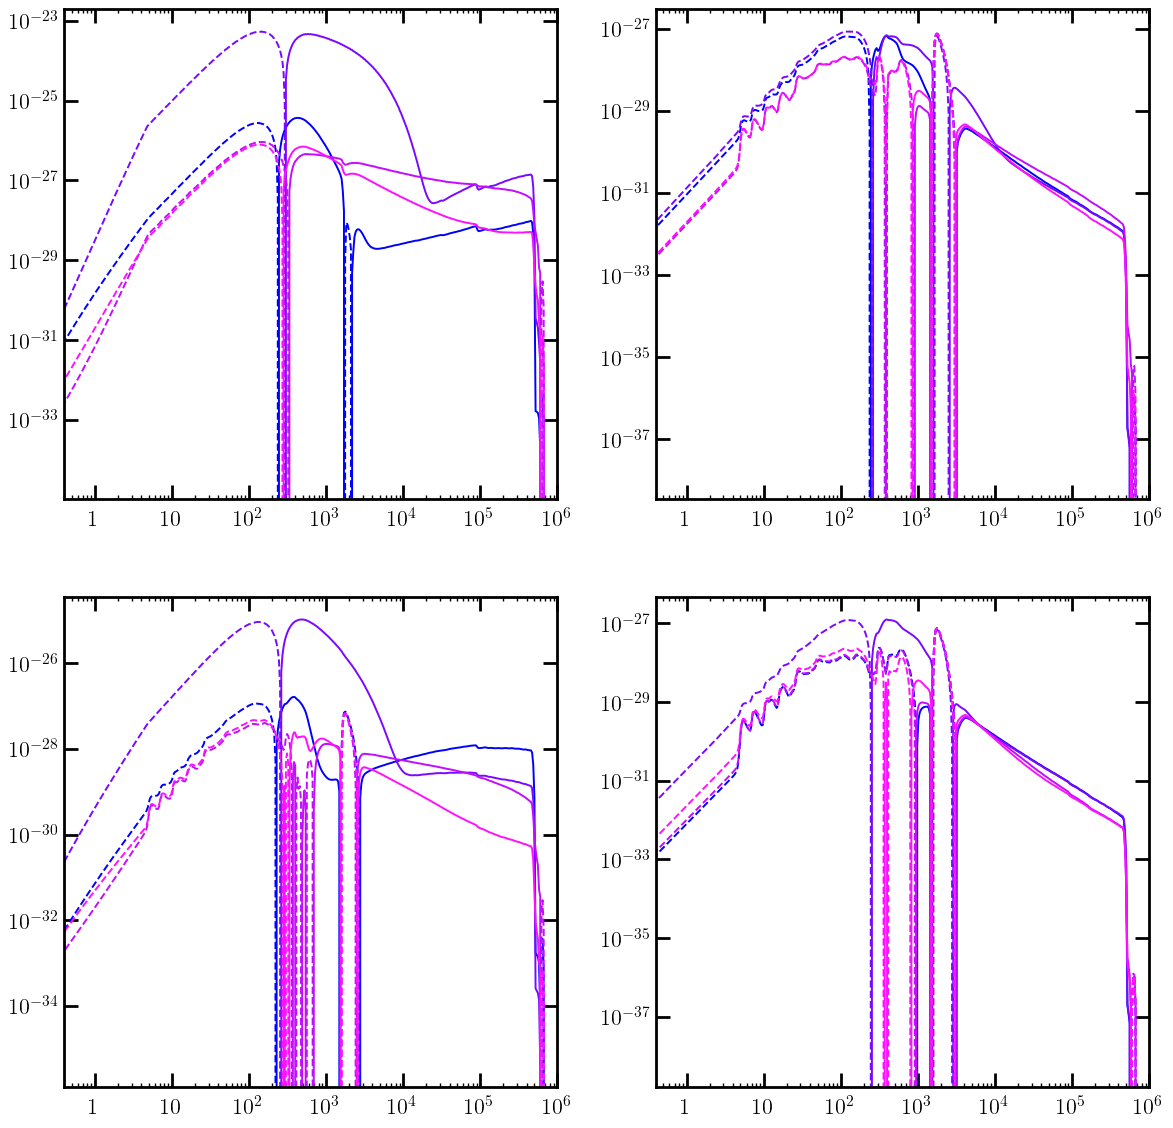

In [185]:
datums = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                       'scan_nmax10_every10th.dat','rb'))

fig, axarr = plt.subplots(2,2, figsize=(14, 14))

cs = np.linspace(0,1,len(datums['elec_decay']))**0.66

for i, pri in enumerate(['elec', 'phot']):
    for j, DM_process in enumerate(['decay', 'swave']):
        axarr[i][j].loglog()
        # plt.xscale('log')
        axarr[i][j].set_xlim([4e-1, 1e6])
#         if DM_process == 'swave':
#             axarr[i][j].set_ylim([6e-30, 2e-26])
#         else:
#             axarr[i][j].set_ylim([6e-30, 8e-24])
        
        model = pri+'_'+DM_process
        
        for k in np.arange(4):
            axarr[i][j].plot(nu/1e9, convert * datums[model][k]['distortion'].dNdE-convert * baseline['distortion'].dNdE,
                             color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
            axarr[i][j].plot(nu/1e9, -convert * datums[model][k]['distortion'].dNdE+convert * baseline['distortion'].dNdE,
                             color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
#             axarr[i][j].plot(nu/1e9, convert * datums[model][k]['distortion'].dNdE,
#                              color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
#             axarr[i][j].plot(nu/1e9, -convert * datums[model][k]['distortion'].dNdE,
#                              color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
#             axarr[i][j].plot(nu/1e9, convert * baseline['distortion'].dNdE,
#              color='k', linewidth=2.4, label='pure recombination (no DM)', alpha=1.0)

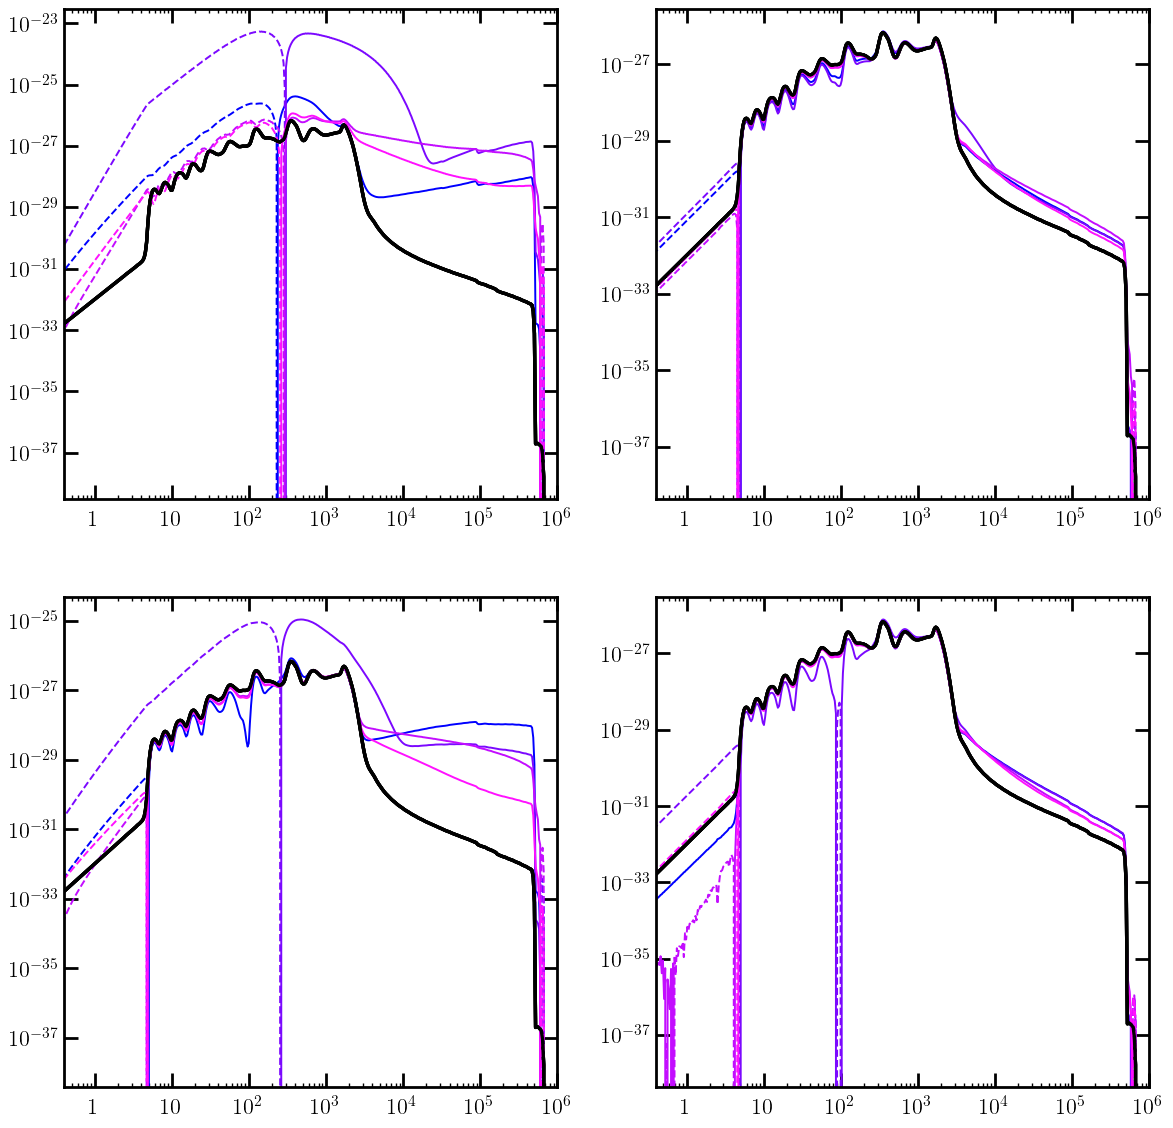

In [184]:
datums = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                       'scan_nmax10_every10th.dat','rb'))

fig, axarr = plt.subplots(2,2, figsize=(14, 14))

cs = np.linspace(0,1,len(datums['elec_decay']))**0.66

for i, pri in enumerate(['elec', 'phot']):
    for j, DM_process in enumerate(['decay', 'swave']):
        axarr[i][j].loglog()
        # plt.xscale('log')
        axarr[i][j].set_xlim([4e-1, 1e6])
#         if DM_process == 'swave':
#             axarr[i][j].set_ylim([6e-30, 2e-26])
#         else:
#             axarr[i][j].set_ylim([6e-30, 8e-24])
        
        model = pri+'_'+DM_process
        
        for k in np.arange(4):
#             axarr[i][j].plot(nu/1e9, convert * datums[model][k]['distortion'].dNdE-convert * baseline['distortion'].dNdE,
#                              color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
#             axarr[i][j].plot(nu/1e9, -convert * datums[model][k]['distortion'].dNdE+convert * baseline['distortion'].dNdE,
#                              color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
            axarr[i][j].plot(nu/1e9, convert * datums[model][k]['distortion'].dNdE,
                             color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
            axarr[i][j].plot(nu/1e9, -convert * datums[model][k]['distortion'].dNdE,
                             color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
            axarr[i][j].plot(nu/1e9, convert * baseline['distortion'].dNdE,
             color='k', linewidth=2.4, label='pure recombination (no DM)', alpha=1.0)

In [146]:
log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])
log10eng[-1] = 12.601505994846297

models = ['elec_decay', 'elec_swave', 'phot_decay', 'phot_swave']
data2 = {model : [] for model in models}

for pri in ['elec', 'phot']:
    for DM_process in ['decay', 'swave']:
        
        model = pri+'_'+DM_process
        print('starting', model)
        
        if pri=='elec':
            if DM_process=='decay':
                mDM_list = 2*(10**log10eng + phys.me)
            else:
                mDM_list = 10**log10eng + phys.me

        elif pri=='phot':
            if DM_process=='decay':
                mDM_list = 2*10**log10eng
            else:
                mDM_list = 10**log10eng
        
        for mDM in tqdm(mDM_list[5::10]):
            
            param = param_bound(mDM, DM_process, pri)

            goods = main.evolve(
                DM_process=DM_process, mDM=mDM,
                lifetime=param,
                sigmav = param,
                primary=pri+'_delta',
                start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
                coarsen_factor=coarsen_factor, backreaction=True,
                distort=True, recfast_TLA=True,
                fexc_switch = True, reprocess_distortion=True, nmax=nmax
            )
            
            data2[model].append(goods)
            
pickle.dump(data2, open('/Users/gregoryridgway/Desktop/Data/'+
                       'scan_nmax10_every10th_5.dat','wb'))

starting elec_decay


/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_58792/567884332.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for mDM in tqdm(mDM_list[5::10]):


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/400.0 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Scratch Work

In [136]:
%autoreload
DM_run_fcont = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=lifetime,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=coarsen_factor, backreaction=False,
    cross_check=False, distort=False, recfast_TLA=True,
    fexc_switch=True, nmax=nmax
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

0.008017952653325142
0.32658172814614705
0.6643936413646182
0.35060232080204035


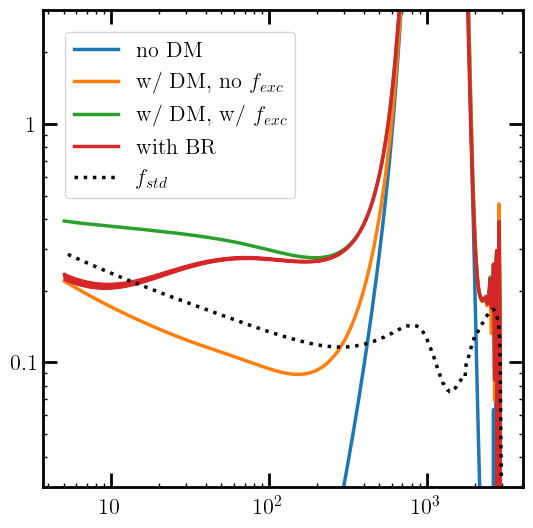

In [298]:
plt.figure()
plt.loglog()
plt.ylim([3e-2, 3])

norm_facs = (
    phys.nB * baseline['rs']**3 /
    (.001*coarsen_factor / phys.hubble(baseline['rs'])) / 
    phys.inj_rate('decay', baseline['rs'], mDM, lifetime=lifetime)
)

tmp_base = np.squeeze(
    baseline['distortions'].toteng('eng', np.array([1e-12,10.2]))
) * norm_facs

strings = ['no DM', 'w/ DM, no $f_{exc}$', 'w/ DM, w/ $f_{exc}$', 'with BR']
# for tmp in [DM_run, DM_run_withf]:
for lab, tmp in zip(strings,[baseline, DM_run, DM_run_withf, DM_run_withf2]):
    print(tmp['distortion'].toteng())
    f_cont_input = np.squeeze(
        tmp['distortions'].toteng('eng', np.array([1e-12,10.2]))
    ) * norm_facs
    
#     plt.plot(tmp['rs'][1:], f_cont_input[1:]-tmp_base[1:])
    plt.plot(tmp['rs'][1:], f_cont_input[1:], label=lab)
    
# plt.plot(DM_run_fcont['rs'][1:], DM_run_fcont['f']['cont'][1:],
#          label='main.evolve(), no distortion')
    
plt.plot(tmp['rs'][1:], phys.f_std(
    mDM, tmp['rs'][1:], pri, DM_process, channel='cont'),
        'k:', label = '$f_{std}$')

plt.legend()

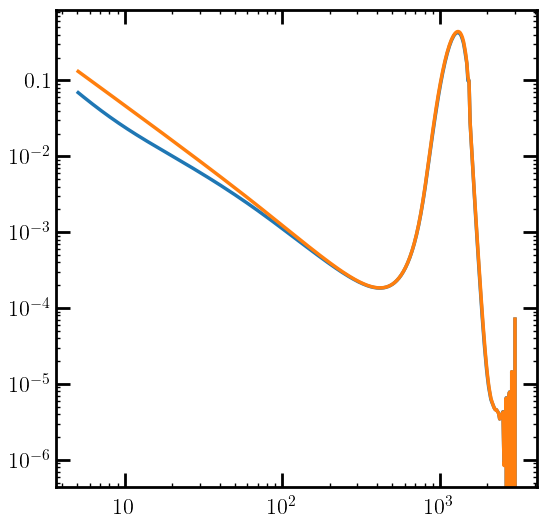

In [302]:
plt.figure()
plt.loglog()
plt.plot(DM_run_withf_withDf2['rs'], DM_run_withf_withDf2['distortions'].toteng())
plt.plot(DM_run_withf['rs'], DM_run_withf['distortions'].toteng())

In [202]:
import pickle
data = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                        'iter0_elec_decay_nmax100_endrs5_03_22.dat','rb'))

In [203]:
# spectra of lowengphots
ind = 5
tmp = data[1][ind]['lowengphot'].copy()

# mask out ionizing photons
mask = np.array(list(map(float,tmp.eng<13.6)))
tmp._grid_vals = tmp._grid_vals * mask

# redshift then sum
tmp.redshift(1.)
tmp = tmp.sum_specs()

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

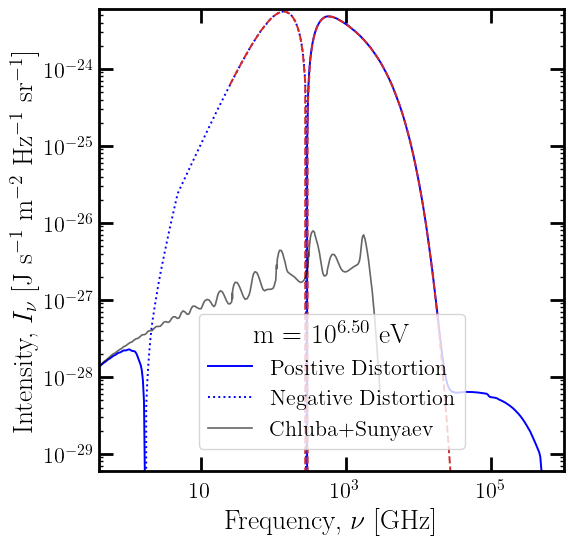

In [208]:
eng = baseline['distortion'].eng

hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
rs_fac = 1300


plt.figure(figsize=(6,6))
plt.loglog()
plt.xlim([4e-1, 1e6])
plt.ylim([6e-30, 6e-24])

# DH generated data
# plt.plot(nu/1e9, convert * baseline['distortion'].dNdE,
#          color='C0', linewidth=1.4, label='no DM')
# plt.plot(nu/1e9, convert * DMrun['distortion'].dNdE,
#          color='blue', linewidth=1.4, label='w/ DM, (+)')
# plt.plot(nu/1e9, -convert * DM_run['distortion'].dNdE,
#          color='red', linewidth=1.4, label='w/ DM, (-)')

plt.plot(nu/1e9, convert * data[1][ind]['distortion'].dNdE,
         color=(0,0,1), linewidth=1.4, label='Positive Distortion')
plt.plot(nu/1e9, -convert * data[1][ind]['distortion'].dNdE,
         color='blue', linestyle=':', linewidth=1.4, label='Negative Distortion')

plt.plot(tmp.eng/hplanck/1e9, phys.nB * tmp.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4 * tmp.dNdE,
         color='C3', linestyle='--', linewidth=1.4)
plt.plot(tmp.eng/hplanck/1e9, -phys.nB * tmp.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4 * tmp.dNdE,
         color='C3', linestyle='--', linewidth=1.4)


# Data from Jens Chluba et al's papers
plt.plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='k',
         linewidth=1.2, label='Chluba+Sunyaev', alpha=0.6)
# plt.plot(n10_data[:,0], n10_data[:,1], color='k',
#          linewidth=2.0, linestyle='--', label='Jens+')
# plt.plot(n20_data[:,0], n20_data[:,1], color='k', linewidth=1.0, linestyle=':')
# plt.plot(n30_data[:,0], n30_data[:,1], color='k', linewidth=1.2)
# plt.plot(jens_data[:,0], jens_data[:,1], color='k', linewidth=2.0, linestyle='--')

string = '{:.2f}'.format(np.log10(data[0][ind][0]))
string = r'm = $10^{'+string+'}$ eV'
plt.legend(title=string)

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

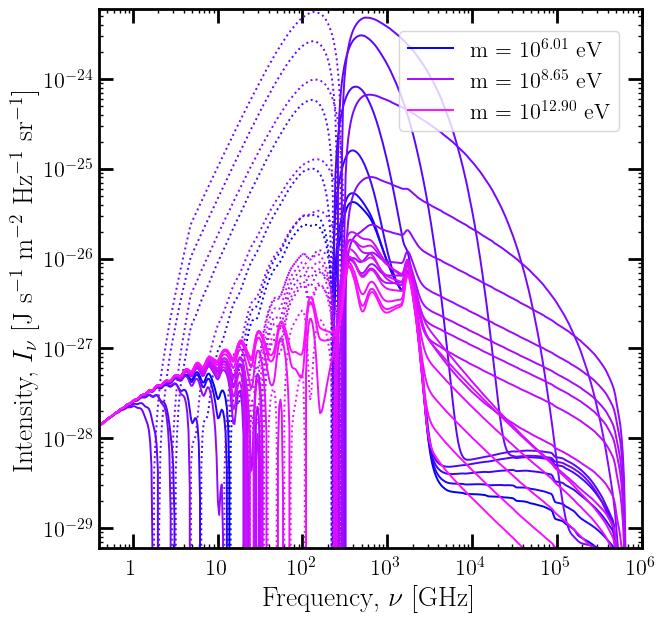

In [178]:
eng = baseline['distortion'].eng

hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
rs_fac = 1300


plt.figure(figsize=(7, 7))
plt.loglog()
plt.xlim([4e-1, 1e6])
plt.ylim([6e-30, 6e-24])

# DH generated data

cs = np.linspace(0,1,len(data[0]))**0.66

for i in np.arange(len(data[0])):
    
    string = '{:.2f}'.format(np.log10(data[0][i][0]))
    string = r'm = $10^{'+string+'}$ eV'
    
    if i==0 or i==19 or i==10:
        plt.plot(nu/1e9, convert * data[1][i]['distortion'].dNdE,
                 color=(cs[i],cs[i]/15,1), linewidth=1.4, label=string)
    else:
        plt.plot(nu/1e9, convert * data[1][i]['distortion'].dNdE,
                 color=(cs[i],cs[i]/15,1), linewidth=1.4)
        
    plt.plot(nu/1e9, -convert * data[1][i]['distortion'].dNdE,
             color=(cs[i],cs[i]/15,1), linewidth=1.4, linestyle=':')

plt.legend()

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

Make sure this isn't coming from low energy photons.

In [170]:
1/phys.hubble(4)/(np.pi*1e7)/1e9

3.190496146330368

In [162]:
tau_bound_elec_CMB(5e6)

2.766300429473599e+24

In [ ]:
data[1][i]['distortions'].toteng()

6.013678810996636 10.646476617926604
6.021675273784309 10.715816751501887
6.044199314851133 11.119177843298438
6.103940160187505 14.092443410780149
6.242237103503343 31.944300903226235
6.496477552807342 91.37484634646543
6.8568684175901975 42.59095579284164
7.279337348227743 20.884583518226314
7.7287777518534595 15.876913993520763
8.188346916909495 12.750747859168726
8.651503224301859 11.783060938842521
9.115903072559847 11.337466320892712
9.58073079837503 11.05955213617763
10.045705368042224 10.655430960373762
10.510730288472578 10.52761330724029
10.975772468233327 10.433373330038625
11.440820563561855 10.318508343281117
11.905870686355396 10.208434482066705
12.370921504021188 10.160226743531343
12.9025360460621 10.142628378555656


Text(0, 0.5, 'Energy Injected into Distortion')

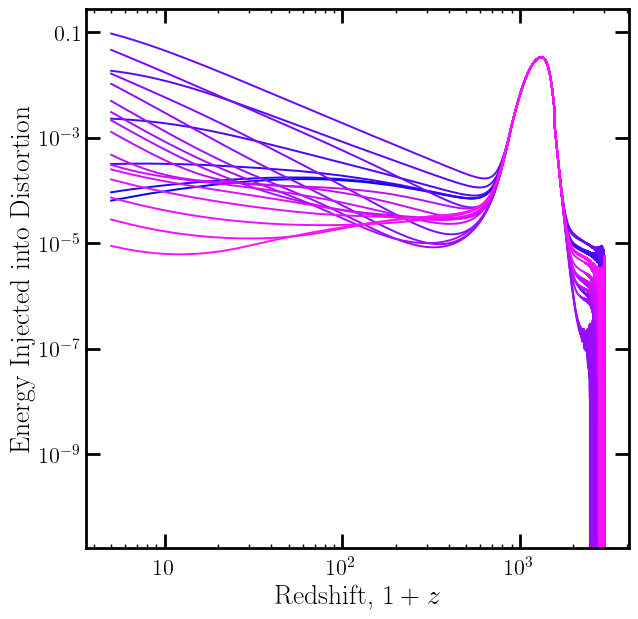

In [165]:
plt.figure(figsize=(7, 7))
plt.loglog()

cs = np.linspace(0,1,len(data[0]))**0.66


for i in np.arange(len(data[0])):
    print(np.log10(data[0][i][0]), sum(data[1][i]['distortions'].toteng()))
    plt.plot(data[1][i]['rs'], data[1][i]['distortions'].toteng(),
             color=(cs[i],cs[i]/15,1), linewidth=1.4)

# plt.legend(loc=2)

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Energy Injected into Distortion', fontsize=20)

In [ ]:
fig, axarr = plt.subplots(1,2, figsize=(14, 7))
axarr[0].loglog()
axarr[0].set_ylim([1e-22, 1e-8])

axarr[0].plot(DMrun_withf['rs'], DMrun_withf['MLA'][0][1:], label=r'$\alpha$, no $f_{exc}$')
axarr[0].plot(DMrun_withf['rs'], DMrun_withf['MLA'][1][1:], label=r'$\beta$, no $f_{exc}$')

axarr[0].plot(DMrun['rs'], DMrun['MLA'][0][1:], label=r'$\alpha$, w/ $f_{exc}$')
axarr[0].plot(DMrun['rs'], DMrun['MLA'][1][1:], label=r'$\beta$, w/ $f_{exc}$')

# axarr[0].plot(DM_run0['rs'], phys.alpha_recomb(Tm_vec, 'HI') + 0*xe_vec**2*nH_vec)
# rate = phys.beta_ion(Tr_vec, 'HI') * x2_vec
# axarr[0].plot(DM_run0['rs'], rate)

axarr[0].set_xlabel('Redshift, $1+z$')
axarr[0].set_ylabel('Recombination/Ionization Rates, [$s^{-1}$]')
axarr[0].legend()

# plt.plot(DM_run_withf0['rs'], np.abs(DM_run_withf0['MLA'][0][1:]/DM_run0['MLA'][0][1:]-1),
#          label=r'$\alpha$')


axarr[1].loglog()
axarr[1].set_ylim([1e-3, 1])
axarr[1].plot(DMrun_withf['rs'], DMrun_withf['MLA'][1][1:]/DMrun['MLA'][1][1:]-1,
         label=r'$\Delta \beta$')

axarr[1].axvline(600, linestyle='--', color='k', label=r'$1+z=600$')

axarr[1].legend()
axarr[1].set_xlabel('Redshift, $1+z$')
axarr[1].set_ylabel('Fractional Difference in Ionization Rate')

In [140]:
mDM = data[0][ind][0]

MLA_funcs = np.array([
    interp1d(data[1][ind]['rs'], data[1][ind]['MLA'][0][1:]),
    interp1d(np.log(data[1][ind]['rs']), np.log(data[1][ind]['MLA'][1][1:]))
])

f_raw = {key: interp1d(data[1][ind]['rs'], data[1][ind]['f'][key],
                       bounds_error=False, fill_value = (0,0))
         for key in data[1][ind]['f'].keys()}

def f_H_ion(rs, xHI, xHeI, xHeII):
    return f_raw['H ion'](rs)
def f_heat(rs, xHI, xHeI, xHeII):
    return f_raw['heat'](rs)
def f_H_exc(rs, xHI, xHeI, xHeII):
    return f_raw['Lya'](rs)

def rate_func_eng(rs):
    return phys.inj_rate(DM_process, rs, mDM=mDM, lifetime=tau_bound_elec_CMB(mDM))

rs_vec = np.exp(np.arange(np.log(3e3),np.log(5.4),-.001))

iterated = tla.get_history(
    rs_vec, high_rs=np.inf,
    f_H_ion=f_H_ion, f_H_exc=f_H_exc, f_heating=f_heat,
    injection_rate=rate_func_eng,
    recfast_TLA=False,
    alpha_MLA=MLA_funcs[0], beta_MLA=MLA_funcs[1],
    mxstep=10000, rtol=1e-8
)

In [155]:
data[0].squeeze()

array([1.03199789e+06, 1.05117561e+06, 1.10713177e+06, 1.27039905e+06,
       1.74677555e+06, 3.13673300e+06, 7.19231033e+06, 1.90255556e+07,
       5.35522536e+07, 1.54293246e+08, 4.48232378e+08, 1.30587940e+09,
       3.80829689e+09, 1.11097777e+10, 3.24138254e+10, 9.45741547e+10,
       2.75943751e+11, 8.05138671e+11, 2.34920818e+12, 7.98980254e+12])

In [ ]:
ran = 10**np.arange(6, 12, .1)

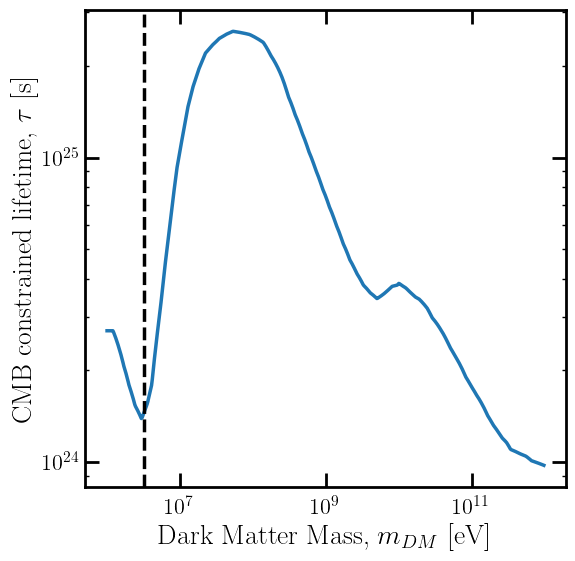

In [214]:
plt.figure()
plt.loglog()

ran = 10**np.arange(6, 12, .01)

plt.plot(ran, tau_bound_elec_CMB(ran))
plt.xlabel(r'Dark Matter Mass, $m_{DM}$ [eV]', fontsize=20)
plt.ylabel(r'CMB constrained lifetime, $\tau$ [s]', fontsize=20)
plt.axvline(10**6.5, color='k', linestyle='--')

In [188]:
log10eng[::10]

array([ 3.69897008,  6.02422598,  8.34948188, 10.67473778])

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_22424/3134640582.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ind in tqdm(np.arange(len(data[0]))):


  0%|          | 0/20 [00:00<?, ?it/s]

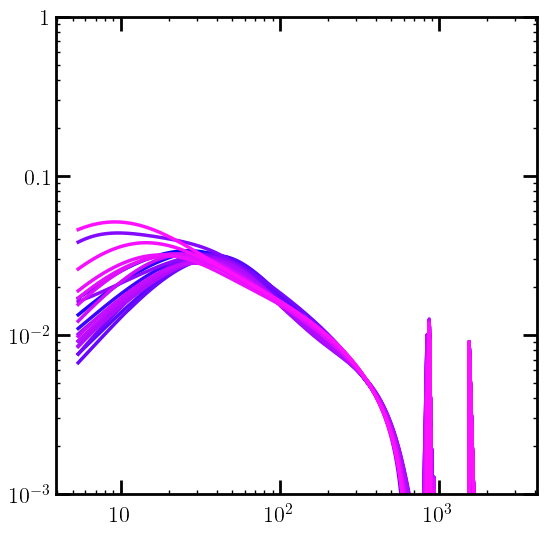

In [147]:
plt.figure()
plt.loglog()
plt.ylim([1e-3,1])

for ind in tqdm(np.arange(len(data[0]))):

    mDM = data[0][ind][0]

    MLA_funcs = np.array([
        interp1d(data[1][ind]['rs'], data[1][ind]['MLA'][0][1:]),
        interp1d(np.log(data[1][ind]['rs']), np.log(data[1][ind]['MLA'][1][1:]))
    ])

    f_raw = {key: interp1d(data[1][ind]['rs'], data[1][ind]['f'][key],
                           bounds_error=False, fill_value = (0,0))
             for key in data[1][ind]['f'].keys()}

    def f_H_ion(rs, xHI, xHeI, xHeII):
        return f_raw['H ion'](rs)
    def f_heat(rs, xHI, xHeI, xHeII):
        return f_raw['heat'](rs)
    def f_H_exc(rs, xHI, xHeI, xHeII):
        return f_raw['Lya'](rs)

    def rate_func_eng(rs):
        return phys.inj_rate(DM_process, rs, mDM=mDM, lifetime=tau_bound_elec_CMB(mDM))

    rs_vec = np.exp(np.arange(np.log(3e3),np.log(5.4),-.001))

    iterated = tla.get_history(
        rs_vec, high_rs=np.inf,
        f_H_ion=f_H_ion, f_H_exc=f_H_exc, f_heating=f_heat,
        injection_rate=rate_func_eng,
        recfast_TLA=False,
        alpha_MLA=MLA_funcs[0], beta_MLA=MLA_funcs[1],
        mxstep=10000, rtol=1e-8
    )

    plt.plot(rs_vec, iterated[:,1]/data[1][ind]['x'][:6320,0]-1,
            color=(cs[ind],cs[ind]/15,1))
# plt.plot(baseline['rs'], baseline['x'][:,0])
# plt.plot(rs_vec, iterated[:,1])
# plt.plot(rs_vec, iterated_withf[:,1])

TODO
- check the baseline scenario (no DM injection). See how much comes from difference between BB and truth, but also numerical precision (n=100 approx)
- one second iteration to show that the iteration procedure works
- Include reionization, make sure it's consistent with Planck's 2sigma region, see if dominant contribution comes from latest times (that we're not keeping track of)
- understand where the features come from

$\chi \to e^+ e^-$

In [40]:
baseline = pickle.load(open('/Users/gregoryridgway/Desktop/Data/iter0_phot_decay_nmax100_endrs5.dat','rb'))

In [41]:
sum(~np.isnan(baseline[1][0]['distortions'].toteng()))

6397

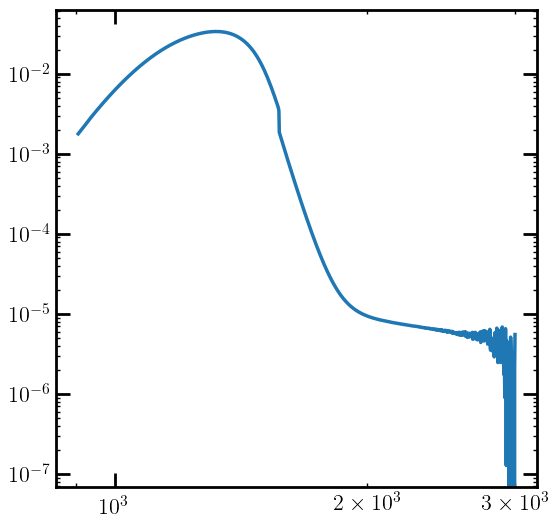

In [43]:
plt.figure()
plt.loglog()
plt.plot(baseline[1][0]['rs'][:1200], baseline[1][0]['distortions'].toteng()[:1200])